# cs4 scipy bpm

`1010.13.May.20`

The last notebook was getting on the long side, so I needed to break off with a new one.

## Optimizing All Areas Together

`1400.07.May.20`

To do all turbines together, I'll have to have separate constraints for separate turbines. As far as I know, I can only have constraints on all things, not just individuals. I'll have to figure out how to code this up.

In [1]:
#--- Load boundary, turb attributes, and windrose data ---#
%run "../baker_cs34_functions.py"

#-- Load the Boundary --#
fn = "../../startup-files/iea37-boundary-cs4.yaml"
[coordList3a, coordList3b, coordList4a, coordList4b, coordList4c] = getTurbAtrbtCs4YAML(fn)
clsdBP3a = closeBndryList(coordList3a)    # Duplicate the first coordinate for a closed boundary
coordList3b = np.roll(coordList3b, 1)     # Shift our points to the right so rightmost vertex is zero
clsdBP3b = closeBndryList(coordList3b)    # Duplicate the first coordinate for a closed boundary
coordList4a = np.roll(coordList4a, -3)    # Shift our points to the left so rightmost vertex is zero
clsdBP4a = closeBndryList(coordList4a)    # Duplicate the first coordinate for a closed boundary
clsdBP4b = closeBndryList(coordList4b)    # Duplicate the first coordinate for a closed boundary
clsdBP4c = closeBndryList(coordList4c)    # Duplicate the first coordinate for a closed boundary

#- Load the turbine and windrose atributes -#
fname_turb = "../../startup-files/iea37-10mw.yaml"
fname_wr = "../../startup-files/iea37-windrose-cs3.yaml"
wind_dir, wind_dir_freq, wind_speeds, wind_speed_probs, num_speed_bins, min_speed, max_speed = iea37aepC.getWindRoseYAML(fname_wr)
turb_ci, turb_co, rated_ws, rated_pwr, turb_diam = iea37aepC.getTurbAtrbtYAML(fname_turb)
fAEPscale = 1.0
fTCscale = 1.0
fMinDist = 2*turb_diam
numGridLines = 20
nNumRegions = 5

[4, 4, 4, 3, 3]


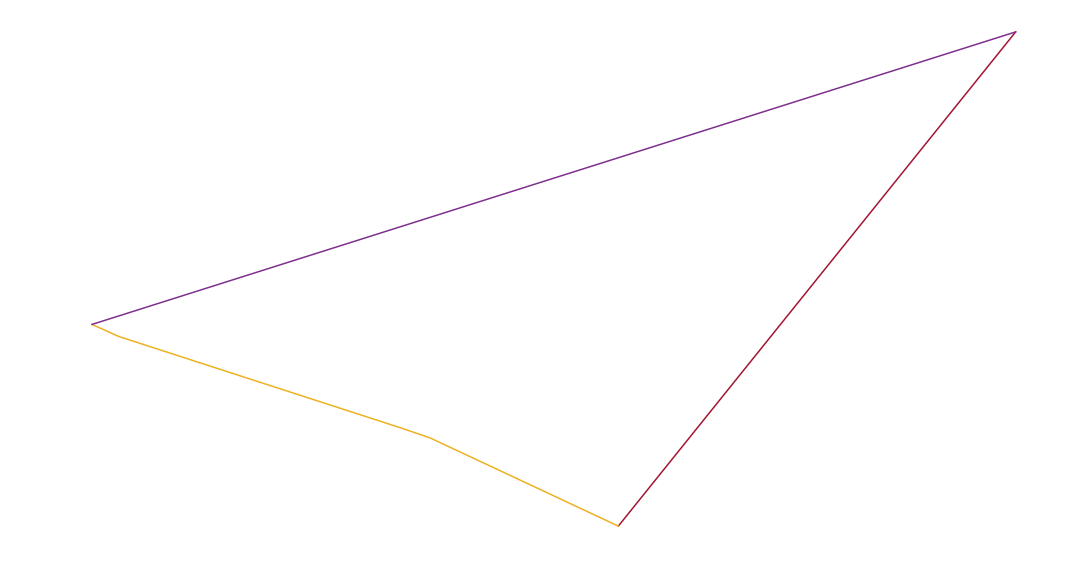

In [98]:
#-- Spline all Boundaries --#
vertexList3a = [0, 6, 8, 9, 18]
numSides3a = len(vertexList3a) - 1      # The number of sides for our original coordinate system.
splineList3a, segCoordList3a = makeCs3BndrySplines(vertexList3a, clsdBP3a, numGridLines)

vertexList3b = [0, 1, 2, 3, 8]       # Hard code the vertices (though this could be done algorithmically)
numSides3b = len(vertexList3b) - 1
splineList3b, segCoordList3b = makeCs3BndrySplines(vertexList3b, clsdBP3b, numGridLines)

vertexList4a = [0, 1, 2, 3, 6]       # Hard code the vertices (though this could be done algorithmically)
numSides4a = len(vertexList4a) - 1      # The number of sides for our original coordinate system.
splineList4a, segCoordList4a = makeCs3BndrySplines(vertexList4a, clsdBP4a, numGridLines)

vertexList4b = [0, 1, 2, 3]       # Hard code the vertices (though this could be done algorithmically)
numSides4b = len(vertexList4b) - 1      # The number of sides for our original coordinate system.
splineList4b, segCoordList4b = makeCs3BndrySplines(vertexList4b, clsdBP4b, numGridLines)

vertexList4c = [0, 1, 4, 5]       # Hard code the vertices (though this could be done algorithmically)
numSides4c = len(vertexList4c) - 1      # The number of sides for our original coordinate system.
splineList4c, segCoordList4c = makeCs3BndrySplines(vertexList4c, clsdBP4c, numGridLines)


# Plot the boundary and the endpoints.
plt.figure(figsize=(20,10))
for i in range(numSides4c):
    plt.hold = True
    printBoundaryArray(segCoordList4c[i].x, splineList4c[i](segCoordList4c[i].x), i+1)
    
numSides = [numSides3a, numSides3b, numSides4a, numSides4b, numSides4c]
print(numSides)

`1633.07.May.20` Need to figure out if you're going to pass the splineList (the list for every section) as a dictionary or an unfilled matrix or what

`1029.13.May.20` Decided to make it a dictionary for data saving (instead of an unfilled matrix)

In [77]:
# Make the matrix to pass in to the function
splineMatDict = {'3a':splineList3a, '3b':splineList3b, '4a':splineList4a, '4b':splineList4b, '4c':splineList4c}
#segCoordMatDict = {'3a':segCoordList3a, '3b':segCoordList3b, '4a':segCoordList4a, '4b':segCoordList4b, '4c':segCoordList4c}
coordsCornersDict = {'3a':clsdBP3a[vertexList3a[0:4]], '3b':clsdBP3b[vertexList3b[0:4]], '4a':clsdBP4a[vertexList4a[0:4]], '4b':clsdBP4b[vertexList4b[0:3]], '4c':clsdBP4c[vertexList4c[0:3]]}

In [57]:
# Get all the random starts from separate areas into one list
nRandoStartNum = 0 # Number 0-199
nTotTurbs = 0
for i in range(nNumRegions):
    nTotTurbs = nTotTurbs + cs34Regions().getNumTurbs(cs34Regions().getRegionName(i))

x0s = []
for i in range(nNumRegions):
    PreStarts = np.loadtxt('../results/randostarts-' + cs34Regions().getRegionName(i) + '-200.csv', delimiter=',')
    x0s.extend(makeArrayCoord(PreStarts[nRandoStartNum]))

print('Total turbines are: ' + str(len(x0s)))
x0 = makeCoordListArray(x0s)

Total turbines are: 81


In [61]:
# Make an array of the number of turbines in each region
nRegionNumTurbs = np.zeros(numRegions, dtype=np.int32)     # Our number of turbines per each region
for i in range(numRegions):
    nRegionNumTurbs[i] = cs34Regions().getNumTurbs(cs34Regions().getRegionName(i))

In [97]:
def checkBndryConsCs4(x0, nNumTurbs, splineMatDict, coordsCornersDict):
    # Pull values from diciontary (splines, corners)
    # Apportion turbines to each area (by index)
    x0s = makeArrayCoord(x0)
    nNumRegions = len(nNumTurbs)
    nTotTurbs = np.sum(nNumTurbs)
    fBndryCons = []
    
    #numSides = 0
    #for i in range(len(coordsCornersDict.keys())):
    #    numSides = numSides + int(len(coordsCornersDict[cs34Regions().getRegionName(i)]))
    
    #-- Loop through and do all regions --#
    piTurbs = 0
    for i in range(nNumRegions):
        niTurbs = (nNumTurbs[i] + piTurbs)  # Next index for our Turbines
        x0region = makeCoordArray(x0s[piTurbs:niTurbs])
        fBndryCons.extend(checkBndryCons(x0region, splineMatDict[cs34Regions().getRegionName(i)], coordsCornersDict[cs34Regions().getRegionName(i)]))
        piTurbs = (nNumTurbs[i] + piTurbs)
    
    return np.asarray(fBndryCons)
    
bndryCons = checkBndryConsCs4(x0, nRegionNumTurbs, splineMatDict, coordsCornersDict)
print(bndryCons)

[1.78847313e+03 2.47702687e+03 1.44414458e+03 4.04695024e+03
 1.16117819e+03 3.10432181e+03 1.60568628e+01 5.80146126e+03
 1.67277541e+02 4.09822246e+03 9.43770263e+01 8.78788077e+02
 1.07692562e+03 3.18857438e+03 4.60884114e+03 1.26717078e+03
 3.41896484e+03 8.46535164e+02 4.87132177e+02 1.46935400e+03
 1.66452926e+03 2.60097074e+03 2.71132082e+03 2.84157938e+03
 1.55851077e+03 2.70698923e+03 1.10900958e+02 5.49486602e+03
 2.26760730e+03 1.99789270e+03 2.98539270e+03 1.63207313e+03
 6.95583804e+02 3.56991620e+03 1.37039243e+03 2.00055014e+03
 3.93005009e+03 3.35449908e+02 3.88594952e+02 3.86686615e+02
 2.48477108e+03 1.78072892e+03 3.27651409e+03 8.39052097e+02
 2.98669545e+03 1.27880455e+03 4.01926130e+02 2.55360782e+03
 1.99169231e+03 2.27380769e+03 4.31562826e+03 9.39516821e+02
 5.05984768e+02 3.75951523e+03 2.26780450e+03 2.31392642e+02
 2.69197057e+03 1.57352943e+03 4.47297468e+02 3.18939562e+03
 2.46296279e+03 1.80253721e+03 3.60569308e+01 4.12991194e+03
 2.31514993e+03 1.950350

For above, need to only ffe `checkBndryCons` the proper turbines for the region, and no others.

In [ ]:
def checkTurbSpacingCs4(x0, nNumTurbs, fMinTurbDist):
    #--- Checks turbine spacing in the five (5) discrete regions. Only checks within regions --#
    #-- Constants needed --#
    # The number of regions we're dealing with
    x0s = makeArrayCoord(x0)
    nNumRegions = len(nNumTurbs)
    
    # Number of turbine pairs in each region
    nNumPairs = np.zeros(nNumRegions, dtype=np.int32)
    for i in range(nNumRegions):     
        nNumPairs[i] = int(binom(nNumTurbs[i], 2))
    
    # Array holding the dist. between each pair
    fTurbSpace = np.zeros(np.sum(nNumPairs, dtype=np.int32))
    bSpacing = np.ones(np.sum(nNumPairs, dtype=np.int32))    # False means pair is too close, True means they're ok
    
    # Calculate all the spacing for our turbines (each region separately)
    piTurbs = 0
    piPairs = 0
    for i in range(nNumRegions):
        niTurbs = (nNumTurbs[i] + piTurbs)  # Next index for our Turbines
        niPairs = (nNumPairs[i] + piPairs)  # Next index for our pair counting 
        [fTurbSpace[piPairs:niPairs], bSpacing[piPairs:niPairs]]= checkTurbSpacing(x0s[piTurbs:niTurbs], fMinTurbDist) 
        piTurbs = (nNumTurbs[i] + piTurbs)
        piPairs = (nNumPairs[i] + piPairs)
 
    return fTurbSpace, bSpacing

print(checkTurbSpacingCs4(x0, nNumTurbs, fMinDist))

# ToDo:

- [x] Load the separate boundaries
- [x] Make the boundary checking function (which checks each turbine in its area) `1345.13.May.20`
- [x] Get SciPy to work with the cs4 Trub and Bndry constraints `1421.13.May.20`
-------------------------------------
- [ ] Restarts (20 at least)
-------------------------------------
- [ ] Get SNOPT to work
- [ ] BNM
- [ ] Exact Gradients
-------------------------------------
- [ ] Convert all to Julia
-------------------------------------
- [ ] WEC
- [ ] PJ's variable reduction